## Noisy RGB pixels + Albedo + Normal, Fit residual, L1 loss, 1/8 U-Net bottleneck

In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


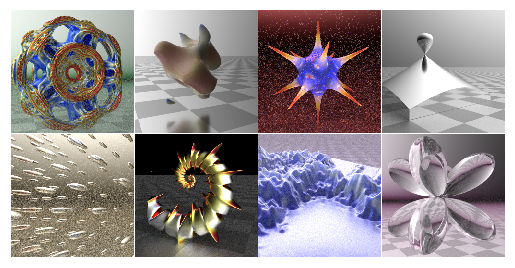

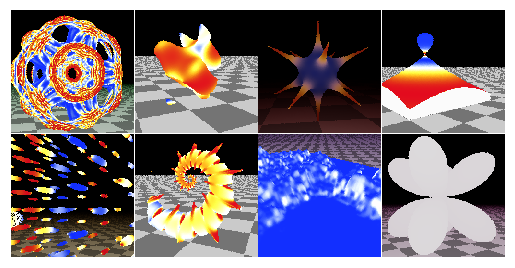

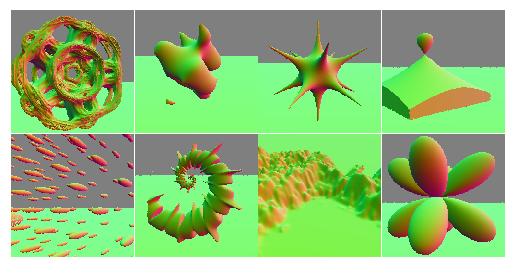

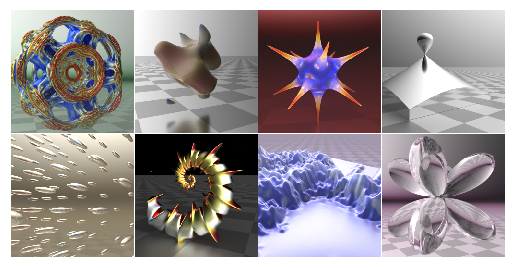

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(a[:, 0:3])
plot_imgs(a[:, 3:6]*0.5+0.5)
# plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.econv0a = conv3(11, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1 = conv3(n0, n1) # 1/2
        self.econv2 = conv3(n1, n2) # 1/4
        self.mconv1 = conv3(n2, n3) # 1/8
        self.mconv2 = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv3(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv3(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv3(n0+n0, n0) # 1
        # self.dconv0 = conv3(n0+n0, 3) # 1
        self.dconv0 = conv3(n0, 3) # 1
        # self.oconva = conv3(n0+n0, 3) # 1
        # self.oconvb = conv3(n0, 3) # 1

    def forward(self, input):
        e0 = self.econv0b(relu(self.econv0a(input))) # 1
        e1 = self.econv1(pool(e0)) # 1/2
        e2 = self.econv2(pool(e1)) # 1/4
        m1 = self.mconv1(pool(e2)) # 1/8
        m2 = self.mconv2(relu(m1)) # 1/8
        d2 = relu(self.dconv2a(relu(m2))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        return self.dconv0(do)
        # return self.dconv0b(concat(d0, e0))
        return self.oconva(concat(d0, e0)) + self.oconvb(do)


model = Model().to(device)
print(model)

Model(
  (econv0a): Conv2d(11, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv1): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv0a): ConvTranspose2d(16, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv0b): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv0): Conv2d(12,

128 0.01404135674238205
256 0.025348922237753868
384 0.011769603006541729
512 0.028361668810248375
640 0.023427821695804596
768 0.029452724382281303
896 0.027371902018785477
1024 0.017205504700541496
1152 0.041807033121585846
1280 0.0757846012711525
1408 0.018945997580885887
1536 0.015873461961746216
1664 0.012360848486423492
1792 0.011425095610320568
1920 0.018890075385570526
2048 0.023985138162970543
2176 0.017998551949858665
2304 0.016866132616996765
2432 0.015227807685732841
2560 0.012897104024887085
2688 0.018396779894828796
2816 0.016983717679977417
2944 0.0314786434173584
3072 0.009677773341536522
3200 0.010796274058520794
3328 0.015851717442274094
3456 0.02134191244840622
3584 0.006053601857274771
3712 0.01486519630998373
3840 0.0075868102721869946
3968 0.0056146252900362015
4096 0.004375608637928963


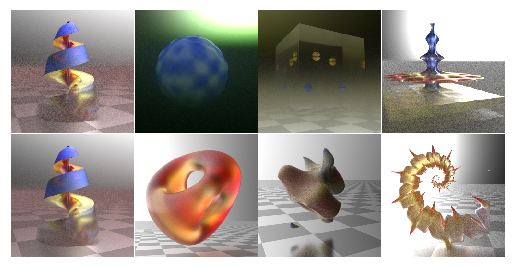

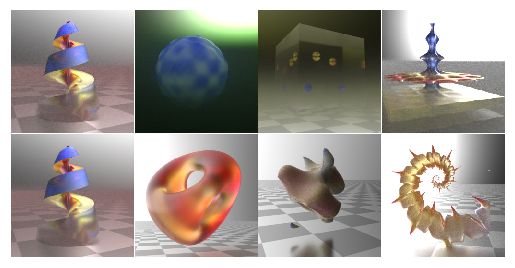

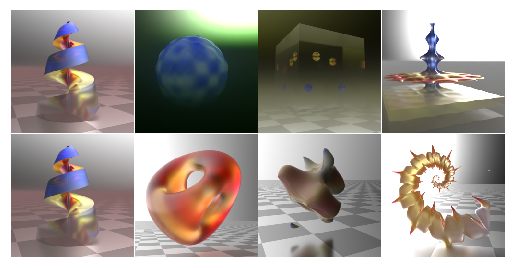

4224 0.01625598967075348
4352 0.013474935665726662
4480 0.011889073997735977
4608 0.010778412222862244
4736 0.010118505917489529
4864 0.012719377875328064
4992 0.014002728275954723
5120 0.02024245820939541
5248 0.01934145577251911
5376 0.011466587893664837
5504 0.010781793855130672
5632 0.01481478102505207
5760 0.009555584751069546
5888 0.0187197457998991
6016 0.02044927328824997
6144 0.014945005998015404
6272 0.013353626243770123
6400 0.020473210141062737
6528 0.01685851626098156
6656 0.016943123191595078
6784 0.010877943597733974
6912 0.011239702813327312
7040 0.017770156264305115
7168 0.014255447313189507
7296 0.00763275008648634
7424 0.013135774061083794
7552 0.006745609454810619
7680 0.013052908703684807
7808 0.009122112765908241
7936 0.016233205795288086
8064 0.01012288685888052
8192 0.00783055555075407


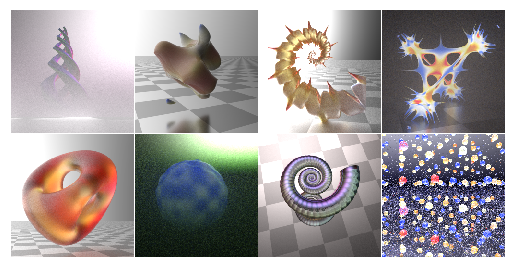

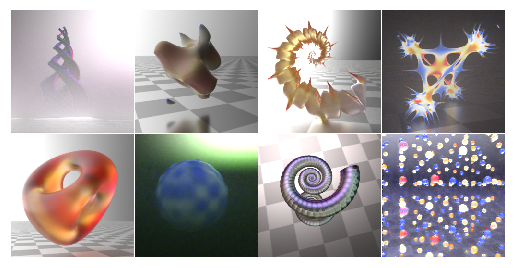

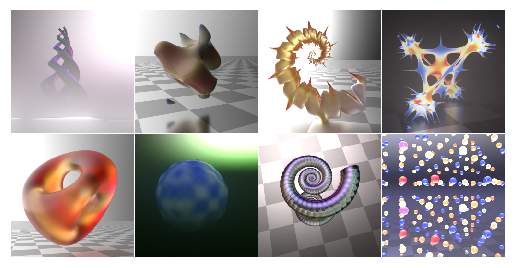

8320 0.011394821107387543
8448 0.01077566109597683
8576 0.017072005197405815
8704 0.005131155252456665
8832 0.009030206128954887
8960 0.006061342544853687
9088 0.012212565168738365
9216 0.015816524624824524
9344 0.011714039370417595
9472 0.005319460295140743
9600 0.012882600538432598
9728 0.006125152111053467
9856 0.006062183529138565
9984 0.014636276289820671
10112 0.00905010849237442
10240 0.0065470486879348755
10368 0.015278734266757965
10496 0.006725687067955732
10624 0.006168495863676071
10752 0.011505817994475365
10880 0.00868780817836523
11008 0.011094316840171814
11136 0.011642949655652046
11264 0.010979201644659042
11392 0.005375292152166367
11520 0.013975652866065502
11648 0.011220659129321575
11776 0.011058091185986996
11904 0.020649736747145653
12032 0.013206969015300274
12160 0.012858348898589611
12288 0.01702651008963585


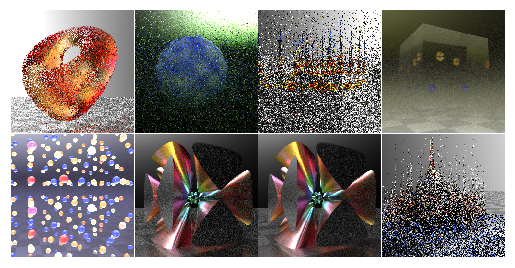

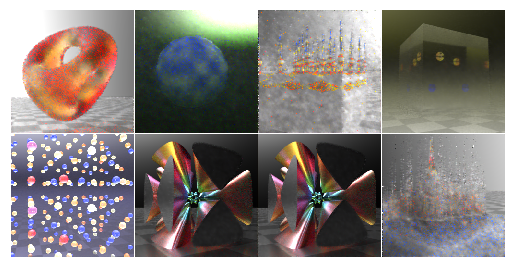

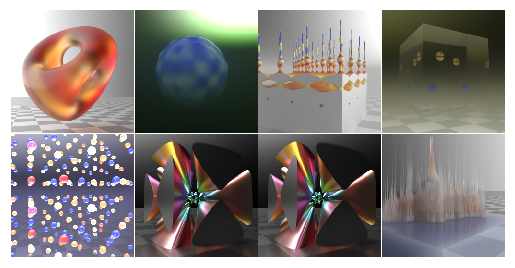

12416 0.013906317763030529
12544 0.010114168748259544
12672 0.017295412719249725
12800 0.006305241491645575
12928 0.018062718212604523
13056 0.01251375861465931
13184 0.010575390420854092
13312 0.013491716235876083
13440 0.008756241761147976
13568 0.015024970285594463
13696 0.008181189186871052
13824 0.017161589115858078
13952 0.003494496224448085
14080 0.011956991627812386
14208 0.009798534214496613
14336 0.011546451598405838
14464 0.007316697388887405
14592 0.009568923152983189
14720 0.016805604100227356
14848 0.014576485380530357
14976 0.011197063140571117
15104 0.011431530117988586
15232 0.006175286136567593
15360 0.007322131656110287
15488 0.010431990027427673
15616 0.008061977103352547
15744 0.009596476331353188
15872 0.007995499297976494
16000 0.010662990622222424
16128 0.011259513907134533
16256 0.008397568017244339
16384 0.013154338113963604


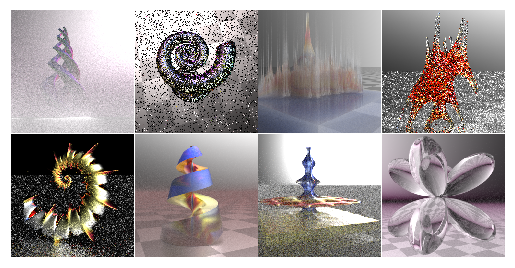

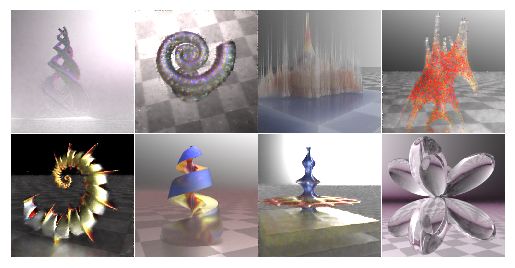

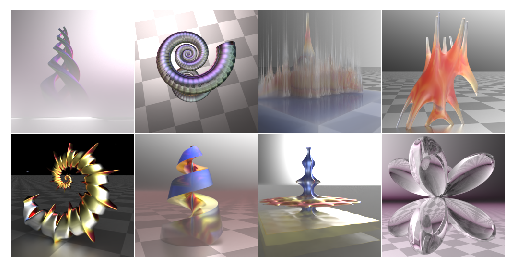

16512 0.0076432316564023495
16640 0.006361344363540411
16768 0.010101057589054108
16896 0.01182651799172163
17024 0.010017165914177895
17152 0.012312334030866623
17280 0.010489087551832199
17408 0.013944363221526146
17536 0.012503284029662609
17664 0.011534271761775017
17792 0.006764795631170273
17920 0.00516168400645256
18048 0.00959797389805317
18176 0.0141538605093956
18304 0.0049523781053721905
18432 0.015318576246500015
18560 0.008309124037623405
18688 0.010527419857680798
18816 0.010032668709754944
18944 0.01176828145980835
19072 0.009787091054022312
19200 0.010366123169660568
19328 0.007726379670202732
19456 0.020601268857717514
19584 0.005226734094321728
19712 0.0179823599755764
19840 0.010475225746631622
19968 0.007665700279176235
20096 0.007988767698407173
20224 0.010541684925556183
20352 0.005646467208862305
20480 0.010778231546282768


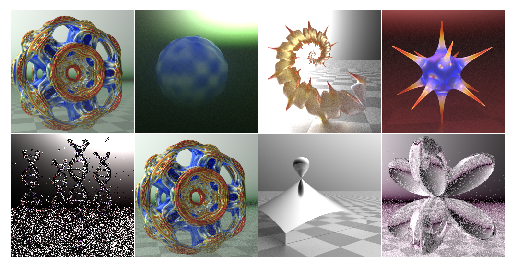

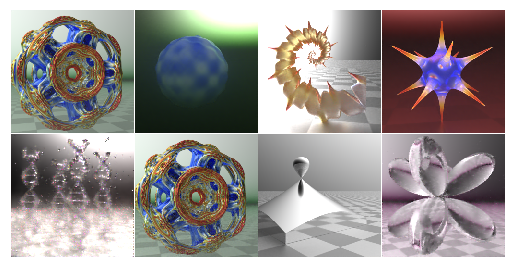

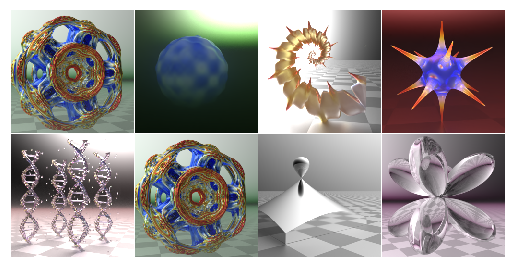

20608 0.010343965142965317
20736 0.007807502057403326
20864 0.016766685992479324
20992 0.006681391503661871
21120 0.009184416383504868
21248 0.01267293468117714
21376 0.00809137150645256
21504 0.005683738738298416
21632 0.010511900298297405
21760 0.007361013442277908
21888 0.011108356527984142
22016 0.016696598380804062
22144 0.008960412815213203
22272 0.00811208225786686
22400 0.006305461283773184
22528 0.008706715889275074
22656 0.016342822462320328
22784 0.009814657270908356
22912 0.005573388189077377
23040 0.011241605505347252
23168 0.015330487862229347
23296 0.006284703500568867
23424 0.01270814798772335
23552 0.009630603715777397
23680 0.012353673577308655
23808 0.011798365041613579
23936 0.0051595852710306644
24064 0.016854120418429375
24192 0.007028515450656414
24320 0.018745895475149155
24448 0.011072181165218353
24576 0.009208044037222862


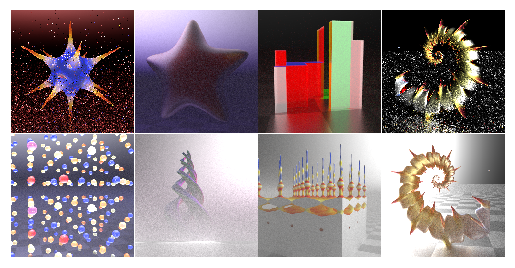

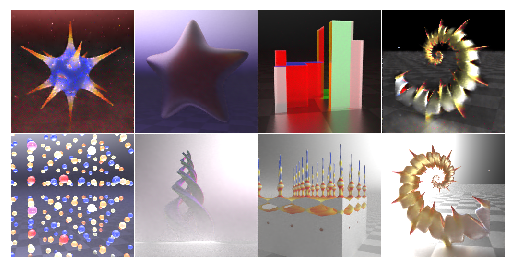

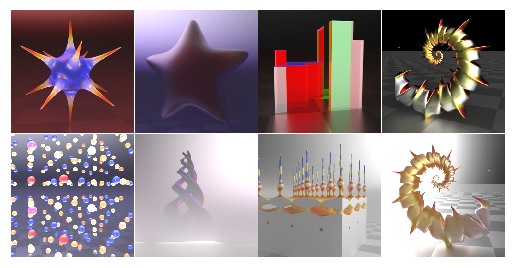

24704 0.01568441465497017
24832 0.007643774151802063
24960 0.012568287551403046
25088 0.010323505848646164
25216 0.00925075076520443
25344 0.015021346509456635
25472 0.007228359114378691
25600 0.01326352171599865
25728 0.005593405570834875
25856 0.004316880367696285
25984 0.004638847894966602
26112 0.016415344551205635
26240 0.00979568250477314
26368 0.003906660713255405
26496 0.011067967861890793
26624 0.009022703394293785
26752 0.002760754432529211
26880 0.008050507865846157
27008 0.008470961824059486
27136 0.012708532623946667
27264 0.014793157577514648
27392 0.006669802125543356
27520 0.008993100374937057
27648 0.01507249753922224
27776 0.007071340456604958
27904 0.008614862337708473
28032 0.011431433260440826
28160 0.0033382498659193516
28288 0.011111132800579071
28416 0.008736243471503258
28544 0.0056469254195690155
28672 0.007663338910788298


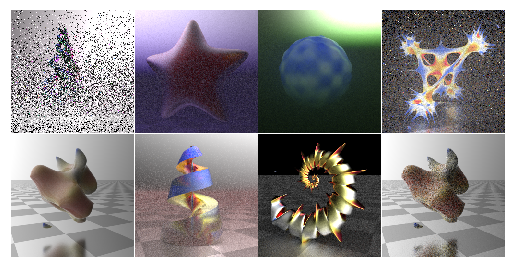

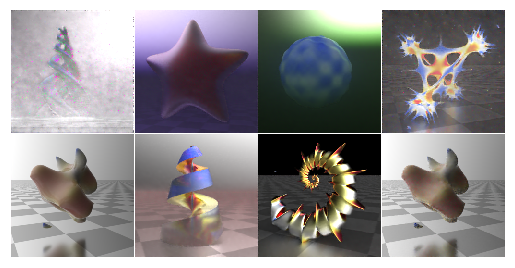

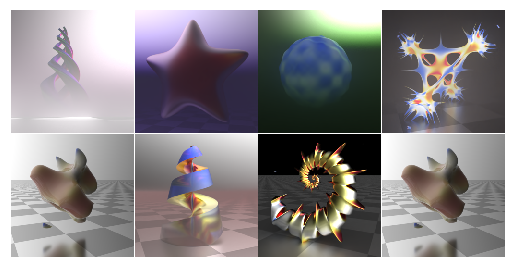

28800 0.013286946341395378
28928 0.004363579209893942
29056 0.003713522106409073
29184 0.004576501436531544
29312 0.011887991800904274
29440 0.007515826262533665
29568 0.0068636550568044186
29696 0.0032272874377667904
29824 0.008515405468642712
29952 0.00546517176553607
30080 0.007196796592324972
30208 0.008970055729150772
30336 0.00581305380910635
30464 0.01046694628894329
30592 0.00677948584780097
30720 0.010313007980585098
30848 0.0054483190178871155
30976 0.012953430414199829
31104 0.007086147554218769
31232 0.014550548046827316
31360 0.006698416080325842
31488 0.011921679601073265
31616 0.011825348250567913
31744 0.006387372966855764
31872 0.009603900834918022
32000 0.009280474856495857
32128 0.020352676510810852
32256 0.005359000526368618
32384 0.008343018591403961
32512 0.004366349894553423
32640 0.006490243133157492
32768 0.01306626945734024


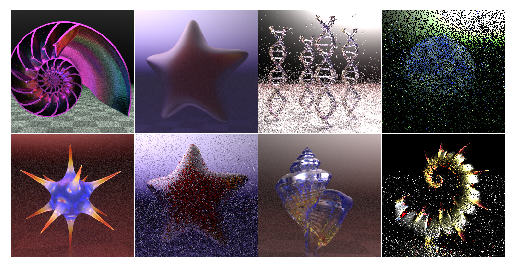

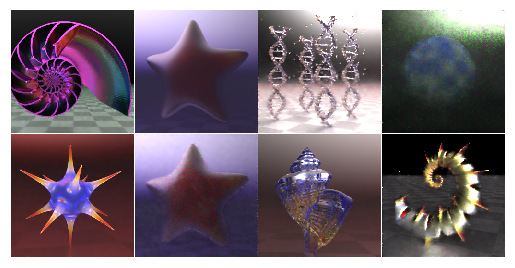

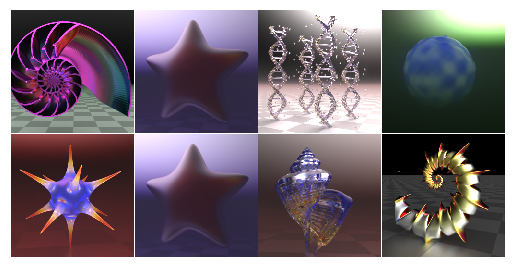

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
    # lr = 0.00001
)

def color_norm(c):
    return (c[:,0:1]**2 + c[:,1:2]**2 + c[:,2:3]**2) ** 0.5

def lossfun(output, reference):
    return torch.mean(torch.abs(output-reference))

model_params = torch.cat([x.view(-1) for x in model.parameters()])

batch_count = 0
for epoch in range(2):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        a = a.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        # x = torch.pow(x, 2.2)
        # y = torch.pow(y, 2.2)
        optimizer.zero_grad()
        m_in = torch.concatenate((
            a[:,0:3], color_norm(a[:,0:3]), # albedo
            a[:,3:6], a[:,3:4]**2+a[:,4:5]**2,  # normal
            x,  # pixels
            ), axis=1)
        output = model(m_in)
        torch.mean(torch.abs(output))
        loss = lossfun(output, y-x)
        # regl1 = 0.1 * torch.mean(torch.abs(model_params))
        # regl2 = 0.1 * torch.mean(torch.abs(model_params))
        # (loss+regl1+regl2).backward()
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 128 == 0:
            print(batch_count, loss.item())
        if batch_count % 4096 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp((output+x).detach())-1)
            plot_imgs(torch.exp(y)-1)
            # plot_imgs(torch.pow(x, 1.0/2.2))
            # plot_imgs(torch.pow(torch.clip(output+x,0.0,1.0).detach(), 1.0/2.2))
            # plot_imgs(torch.pow(y, 1.0/2.2))


In [6]:
torch.save(model, "model3anc_small.pth")